In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Basic movie capture algorithm

In [2]:
cap = cv2.VideoCapture('Robots.mp4')
ret, frame = cap.read()
while ret:
    cv2.imshow('image', frame)
    cv2.waitKey(20)

    """ Do your tracking here """



    ret, frame = cap.read()

    """ Draw the tracking onto the new image here"""

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

cv2.destroyAllWindows()
cap.release()

#### Sparse approach 1 - difference from frame 1

In [16]:
cap = cv2.VideoCapture('Robots.mp4')
ret, frame = cap.read()
firstFrame = None
k = 0
l = []
frame_difference = 10
while ret:
    cv2.resize(frame,(50,30))

    #Detecting movement
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    l.append(gray)
    if firstFrame is None:
        firstFrame = gray
        continue
    feat1 = cv2.goodFeaturesToTrack(gray, maxCorners=1000, qualityLevel=0.4, minDistance=10)
    feat2, status, error = cv2.calcOpticalFlowPyrLK(gray, firstFrame, feat1, None)

    for i in range(len(feat1)):
        f10=int(feat1[i][0][0])
        f11=int(feat1[i][0][1])
        f20=int(feat2[i][0][0])
        f21=int(feat2[i][0][1])

        if np.sqrt((f20-f10)**2 + (f21-f11)**2) > frame_difference:
            cv2.line(frame, (f10,f11), (f20, f21), (0, 255, 0), 2)
            cv2.circle(frame, (f10, f11), 5, (0, 255, 0), -1)

    cv2.imshow('image', frame)
    cv2.waitKey
    

    if k>10:
        firstFrame = l[-9]

    ret, frame = cap.read()
    k+=1
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows()
cap.release()

### Spare approach 2 - rectangles

In [4]:
cap = cv2.VideoCapture('Robots.mp4')
ret, frame = cap.read()
firstFrame = None
while ret:

    if firstFrame is None:
        firstFrame = frame
        continue
    
    diff = cv2.absdiff(frame,firstFrame)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    diff_blur = cv2.GaussianBlur(diff_gray, (5,5), 0)

    _, thresh_bin = cv2.threshold(diff_blur, 100, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh_bin,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    drawframe = frame.copy()

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 100:
            cv2.rectangle(drawframe, (x, y), (x+w, y+h),(0, 255, 0), 2)

    cv2.imshow('image', drawframe)
    cv2.waitKey
    
    firstFrame = frame
    ret, frame = cap.read()
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows()
cap.release()

### Dense approach - Chezch Style

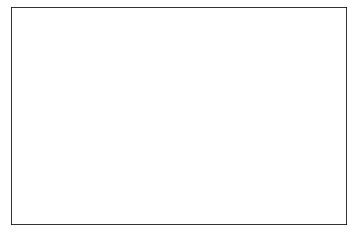

In [5]:
import cv2
cap = cv2.VideoCapture('Robots.mp4')
height = 360
width = 640
cap.set(3, width)
cap.set(4, height)
download = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'MJPG'), 20.0, (width, height),1)

ret, frame_new = cap.read()
frame_new = cv2.resize(frame_new, (width, height), interpolation=cv2.INTER_AREA)
frame_new = cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB)

while ret:
    frame_old = frame_new
    ret, frame_new = cap.read()
    if not ret or (cv2.waitKey(1) & 0xFF == ord('q')): # Pressing q will end the program
        break
    frame_new = cv2.resize(frame_new, (width, height), interpolation=cv2.INTER_AREA)
    frame_new = cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB)
    gray_old = cv2.cvtColor(frame_old, cv2.COLOR_RGB2GRAY)
    gray_new = cv2.cvtColor(frame_new, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(gray_old, gray_new, None, 0.5, 3, 15, 3, 5, 1.5, 0)
    mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Retrieving the magnitude and angle of every pixel

    mask = np.zeros_like(frame_old) # Create empty matrix in dimesions as original image
    mask[..., 1] = 255              # Set image saturation to maximum value as we do not need it
    mask[..., 0] = ang*180/np.pi/2  # Set image hue according to the optical flow direction
    mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # Set image value according to the optical flow magnitude (normalized)
    flow = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)       # Convert HSV to RGB (BGR) color representation
    out = cv2.addWeighted(frame_old, 1, flow, 2, 0)    # Add images together
    plt.xticks([]),plt.yticks([])                      # Turn off coord axis

    cv2.imshow('image', out)
    download.write(out)  # Video download
    #cv2.waitKey(20)     # Wait for 20ms

cv2.destroyAllWindows()
cap.release()
download.release()

### Going advanced

In [12]:
cap = cv2.VideoCapture('Robots.mp4')
ret, frame_new = cap.read()

robot_1 = cv2.imread('turtlebot.png')
robot_1_gray = cv2.cvtColor(robot_1, cv2.COLOR_BGR2GRAY)

frame_old = None

while ret:
    if frame_old is None:
        frame_old = frame_new
        continue

    gray_frame = cv2.cvtColor(frame_new, cv2.COLOR_BGR2GRAY)
    
    # ORB
    # 1 
    orb = cv2.ORB_create()
    diff = cv2.absdiff(frame_new,frame_old)

    kp, des = orb.detectAndCompute(diff, None) #Keypoints and descriptors

    # 3
    kp2, des2 = orb.detectAndCompute(robot_1_gray, None)

    # 4 Match: brute force matcher
    bf = cv2.BFMatcher()
    orb_matches = bf.match(des, des2)
    orb_matches = sorted(orb_matches, key = lambda x:x.distance)

    # Display matches
    image = cv2.drawMatches(gray_frame,kp,robot_1_gray,kp2,orb_matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imshow("image", image)
    #cv2.waitKey(20)

    frame_old = frame_new
    ret, frame_new = cap.read()
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows()
cap.release()

In [7]:
#